# Initial Data Integrity check (can be skipped after being ran once)

In [1]:
import pandas as pd
import os

use_small_train = True

personal_path = "/vol/home/s4316061/CV_assignments/3_assign/"
if use_small_train:
    train_path_of_choice = "jester-v1-small-train.csv"
    data_download_path = 'downloaded_data_small/small-20bn-jester-v1/'
else:
    train_path_of_choice = "jester-v1-train.csv"
    data_download_path = 'something_else_entirely'
    
# valid is the same, regardless of the train set
validation_path = "jester-v1-validation.csv"

train = pd.read_csv(personal_path + train_path_of_choice, sep=';', header=None, names=['id', 'gesture'])
valid = pd.read_csv(personal_path + validation_path, sep=';', header=None, names=['id', 'gesture'])

# get all the directory names of the subdirectories available (data is in 'big_dir/many_small_dirs/actual_images' format)
root = personal_path + data_download_path
subdir_set = {entry.name for entry in os.scandir(root) if entry.is_dir()}

print(train.shape[0] + valid.shape[0])  # sanity check These numbers should match, withing a reasonable degree
print(len(subdir_set)) 

# concatenating the DataFrames for easy querying
train_and_valid = pd.concat([train, valid], axis=0, ignore_index=True)

available_ids = set(train_and_valid['id'].astype(str).unique())

missing_val = available_ids - subdir_set
extra_val = subdir_set - available_ids

print(f"Values (ids) available in csv, but not downloaded: {missing_val} (should be none)")
print(f"Extra values in downloaded, but not in csv: {extra_val}")

# making sure the numbers are the same (possibly redundant, but I like to check sometimes)
print("Manual checks")
val = '74335'
print(val in subdir_set)
print(val in available_ids)

train_ids = set(train['id'].astype(str).unique())
val_ids = set(valid['id'].astype(str).unique())

FileNotFoundError: [Errno 2] No such file or directory: '/vol/home/s4316061/CV_assignments/3_assign/jester-v1-small-train.csv'

## Command cell (Linux ONLY): removes the extra video directory found, as it does not have a correspondent in the csv files
And I won't go searching for 1 item in the 118K row csv file

In [9]:
# !rm -r ~/CV_assignments/3_assign/downloaded_data_small/small-20bn-jester-v1/74335

In [10]:
train_and_valid = train_and_valid[~train_and_valid['id'].astype(str).isin(extra_val)]

# observing output shape, just to assess the overall size of the data available
print(f"new shape: {train_and_valid.shape}")

NameError: name 'train_and_valid' is not defined

# Importing packages project wide

In [2]:
# Data importing, and integrity checking
import os
import pandas as pd
# for easy Path definitions
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms

# for visualizing shadowy images
import matplotlib.pyplot as plt
import numpy as np
import random

# optional (I just like the summary output; install if you want with either pip or conda the package "torchsummary")
from torchsummary import summary

### Seed setting functions

In [3]:
# setting seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
# setting worker seed ids, also for reproducibility (in the DataLoader objects)
def worker_init_fn(worker_id):
    worker_seed = master_seed + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)


master_seed = 42
set_seed(master_seed)
# defining generator
g = torch.Generator()
g.manual_seed(master_seed)

# Data Path definition

I know, we shouldn't need to have this, but we are using 2 systems, with 2 different OS-es, and completely different file management systems

So I say, at least for now, we need it

In [31]:
# Change this string to match the profile key below
CURRENT_USER = "NICO"  # Options: "ALEX", "NICO"
USE_SMALL_DATA = True


# Defining profiles

# 'root': The base folder for the project
# 'csv_dir': Where CSVs live (relative to root)
# 'video_dir': Where the video folders live (relative to root)
PROFILES = {
    "ALEX": {
        "root": Path("/vol/home/s4316061/CV_assignments/3_assign"),  # common path, from system root, to project folder
        "csv_dir": "",  # Empty string means "directly in root", so like: "CV_assignments/3_assign/jester-v1-validation.csv" for me
        "video_dir": "downloaded_data_small",
        "cached_images": "downloaded_data_small",
        # I added this later, to make the training process faster (it is the folder I use to save the mean images,
        # so the script does not calculate the mean every time it wants to load it to the model)
    },
    "NICO": {
        "root": Path("data"),  # Relative path likely works best, you used just "data/" in the shared file, so if it doesn't work, please change as needed
        "csv_dir": "labels",  # so like: "data/labels", where labels is a directory
        "video_dir": "videos",
        "cached_images": "cache"  # change carefully: it needs to be in the same parent directory as your directory for the small dataset, and have
        # "cached_images" as the name. It HAS to match perfectly, otherwise the training will not work
    }
}

# PATH GENERATOR FUNCTION (for all the future instances where we need Paths)
def get_project_paths(user_profile, use_small=True):
    """
    Returns (train_annotation, val_annotation, video_root) based on the user profile.
    """
    if user_profile not in PROFILES:
        raise ValueError(f"Profile '{user_profile}' not found in PROFILES dictionary.")
    
    config = PROFILES[user_profile]
    root = config["root"]
    
    # defining CONSTANT Filenames (these should be the same for both of us, just locations should be different)
    if use_small:
        train_csv_name = "jester-v1-small-train.csv"
        # Matches folder name: "small-20bn-jester-v1"
        dataset_folder_name = "small-20bn-jester-v1"  # should be what the zip file unpacked
    else:
        train_csv_name = "jester-v1-train.csv"
        # Assuming full dataset name; adjust if needed
        dataset_folder_name = "20bn-jester-v1"   # this is guessing, shouldn't be used until we need the full dataset
        
    val_csv_name = "jester-v1-validation.csv"

    mean_cache_folder_name = "mean_cached_images"
    diff_cache_folder_name = "diff_cached_images"

    # Build Full Paths using '/'' operator with logic: Root / Subfolder / Filename (Pathlib magic)
    train_csv_path = root / config["csv_dir"] / train_csv_name
    val_csv_path   = root / config["csv_dir"] / val_csv_name
    
    # point to the FOLDER containing the numbered directories
    video_root_path = root / config["video_dir"] / dataset_folder_name

    # Mean Cache Path: .../downloaded_data_small/mean_cache_images
    mean_cache_path = root / config["cached_images"] / mean_cache_folder_name
    # Diff Cache Path: .../downloaded_data_small/diff_cache_images
    diff_cache_path = root / config["cached_images"] / diff_cache_folder_name

    return train_csv_path, val_csv_path, video_root_path, mean_cache_path, diff_cache_path


# to be ran once for the whole project
train_annotation, val_annotation, video_root, mean_cache_root, diff_cache_root = get_project_paths(CURRENT_USER, USE_SMALL_DATA)

# DEBUG CHECK 
print(f"User: {CURRENT_USER}")
print(f"Train CSV:  {train_annotation}")
print(f"Video Root: {video_root}")
print(f"Mean cache Root: {mean_cache_root}")
print(f"Diff cache Root: {diff_cache_root}")
print(f"Exists?     {train_annotation.exists()} (CSV), {video_root.exists()} (Video Dir), {mean_cache_root.exists()} (mean_cached Dir)")
# .exists is a Pathlib method

train_annotation, val_annotation, video_root, mean_cache_root, diff_cache_root = str(train_annotation), str(val_annotation), str(video_root), str(mean_cache_root), str(diff_cache_root)

User: NICO
Train CSV:  data\labels\jester-v1-small-train.csv
Video Root: data\videos\small-20bn-jester-v1
Mean cache Root: data\cache\mean_cached_images
Diff cache Root: data\cache\diff_cached_images
Exists?     True (CSV), True (Video Dir), True (mean_cached Dir)


# Single image with mean pixel value (baseline data)

## Mean pixel value class

In [7]:
class JesterMeanBaselineDataset(Dataset):
    def __init__(self, data_root, annotation_file, transform=None,
                 text_label_dict=None, trim_percent=0.3, cache_dir=None):
        """
        Args:
            cache_dir (str): Path to a folder where .pt files will be saved.
                             If None, caching is disabled.
        """
        self.cache_dir = cache_dir

        # Create cache directory if it's enabled and doesn't exist
        if self.cache_dir is not None:
            os.makedirs(self.cache_dir, exist_ok=True)
            print(f"Dataset Caching Enabled. Saving .pt files to: {self.cache_dir}")

        self.data_root = data_root
        self.transform = transform
        self.trim_percent = trim_percent  # effectively trims the images by 2 * trim_percent. This is done to
        # keep mostly relevant frames from the image, as usually the first trim_percent frames is the
        # subject starring at the camera, motionless, and so are the last trim_percent frames, making
        # the output image noisy, or motionless

        # load CSV data
        df = pd.read_csv(annotation_file, sep=';', header=None, names=['video_id', 'label'])
        self.video_ids = df['video_id'].astype(str).tolist()
        raw_labels = df['label'].tolist()

        # id_to_label_map for future lookup of predictions (so we can see what the model predicts in language. not numbers)
        self.id_to_label_map = pd.Series(df.label.values, index=df.video_id).to_dict()

        if text_label_dict is not None:
            self.class_to_idx = text_label_dict
        else:
            # creates the gesture: numeric_label map, from the gestures in train. This will be important for Validation later
            unique_labels = sorted(list(set(raw_labels)))
            self.class_to_idx = {label: i for i, label in enumerate(unique_labels)}

        self.labels = [self.class_to_idx[l] for l in raw_labels]

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        # print(f"Attempting to load {idx}")
        video_id = self.video_ids[idx]
        label = self.labels[idx]

        # CACHE PATH: if caching is on, check if we already did the work for this video: saves us A LOT of compute
        if self.cache_dir:
            cache_path = os.path.join(self.cache_dir, f"{video_id}.pt")
            if os.path.exists(cache_path):
                # print(f"Loading {idx} from cache")
                # FAST PATH: Load tensor directly
                mean_image = torch.load(cache_path)
                return mean_image, label

        # SLOW PATH: Calculate from scratch
        video_dir = os.path.join(self.data_root, video_id)

        try:
            frame_names = sorted([x for x in os.listdir(video_dir) if x.endswith('.jpg')])
            # debugging: seeing how many frames there are at the beginning
            # print(f"Video {video_id}: First={frame_names[0]}, Last={frame_names[-1]}")
        except FileNotFoundError:
            print("missed some image")
            return torch.zeros(1), label

        total_frames = len(frame_names)

        # Image trimming
        # calculate how many frames to drop from each side
        cut_amount = int(total_frames * self.trim_percent)
        # it keeps everything if cut is 0.0 (means there aren't enough images to cut trim_percent*2 from)
        if cut_amount > 0:
            # revert to keeping only the middle frame if we cut too much (trim_percent >= 0.5)
            if (total_frames - (2 * cut_amount)) <= 0:
                mid = total_frames // 2
                frame_names = [frame_names[mid]]
            else:
                # trim it up
                frame_names = frame_names[cut_amount : -cut_amount]


        # self.frames_available = len(frame_names)
        # debugging: seeing how many images are left, from how many there were (previous print)
        # print(f"Video {video_id}: First={frame_names[0]}, Last={frame_names[-1]}")

        # Loading and Transforming the remaining frames
        tensors = []
        for frame_name in frame_names:
            img_path = os.path.join(video_dir, frame_name)

            with Image.open(img_path) as img:
                img = img.convert("RGB")

            # Resize/ToTensor happen here
            if self.transform:
                img = self.transform(img)
            tensors.append(img)

        # stack all frames. so  shape (32, 3, H, W)
        stacked_video = torch.stack(tensors)
        # getting the mean along "Time", resulting in a shape of (3, H, W)
        mean_image = torch.mean(stacked_video, dim=0)

        # CACHE SAVE: saving the result so we never have to calculate it again
        if self.cache_dir:
            # torch.save(mean_image, cache_path)  # saves a .pt file, which is much fater for torch to load in the CACHE PATH

            if not os.path.exists(cache_path):
                # Write to a temporary file first
                tmp_path = cache_path + ".tmp"

                try:
                    # Save to temp file
                    torch.save(mean_image, tmp_path)

                    # Atomic replace ensures only one worker succeeds
                    os.replace(tmp_path, cache_path)

                except FileExistsError:
                    # Another worker beat us to it. Safe to ignore.
                    pass
                except Exception as e:
                    # Clean up partial file if something went wrong
                    if os.path.exists(tmp_path):
                        try:
                            os.remove(tmp_path)
                        except:
                            pass
                    print(f"Cache save error for {video_id}: {e}")

        return mean_image, label

## Difference class

In [20]:
class JesterDiffBaselineDataset(Dataset):
    def __init__(self, data_root, annotation_file, transform=None,
                 text_label_dict=None, trim_percent=0.3, cache_dir=None):
        """
        Args:
            cache_dir (str): Path to a folder where .pt files will be saved.
                             If None, caching is disabled.
        """
        self.cache_dir = cache_dir

        # Create cache directory if it's enabled and doesn't exist
        if self.cache_dir is not None:
            os.makedirs(self.cache_dir, exist_ok=True)
            print(f"Dataset Caching Enabled. Saving .pt files to: {self.cache_dir}")

        self.data_root = data_root
        self.transform = transform
        self.trim_percent = trim_percent  # effectively trims the images by 2 * trim_percent. This is done to
        # keep mostly relevant frames from the image, as usually the first trim_percent frames is the
        # subject starring at the camera, motionless, and so are the last trim_percent frames, making
        # the output image noisy, or motionless

        # load CSV data
        df = pd.read_csv(annotation_file, sep=';', header=None, names=['video_id', 'label'])
        self.video_ids = df['video_id'].astype(str).tolist()
        raw_labels = df['label'].tolist()

        # id_to_label_map for future lookup of predictions (so we can see what the model predicts in language. not numbers)
        self.id_to_label_map = pd.Series(df.label.values, index=df.video_id).to_dict()

        if text_label_dict is not None:
            self.class_to_idx = text_label_dict
        else:
            # creates the gesture: numeric_label map, from the gestures in train. This will be important for Validation later
            unique_labels = sorted(list(set(raw_labels)))
            self.class_to_idx = {label: i for i, label in enumerate(unique_labels)}

        self.labels = [self.class_to_idx[l] for l in raw_labels]

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        # print(f"Attempting to load {idx}")
        video_id = self.video_ids[idx]
        label = self.labels[idx]

        # CACHE PATH: if caching is on, check if we already did the work for this video: saves us A LOT of compute
        if self.cache_dir:
            cache_path = os.path.join(self.cache_dir, f"{video_id}.pt")
            if os.path.exists(cache_path):
                # print(f"Loading {idx} from cache")
                # FAST PATH: Load tensor directly
                mean_image = torch.load(cache_path)
                return mean_image, label

        # SLOW PATH: Calculate from scratch
        video_dir = os.path.join(self.data_root, video_id)

        try:
            frame_names = sorted([x for x in os.listdir(video_dir) if x.endswith('.jpg')])
            # debugging: seeing how many frames there are at the beginning
            # print(f"Video {video_id}: First={frame_names[0]}, Last={frame_names[-1]}")
        except FileNotFoundError:
            print("missed some image")
            return torch.zeros(1), label

        total_frames = len(frame_names)

        first_img_path = os.path.join(video_dir, frame_names[0])
        with Image.open(first_img_path) as img:
                first_img = img.convert("RGB")
        if self.transform:
                first_img = self.transform(first_img)

        # Image trimming
        # calculate how many frames to drop from each side
        cut_amount = int(total_frames * self.trim_percent)
        # it keeps everything if cut is 0.0 (means there aren't enough images to cut trim_percent*2 from)
        if cut_amount > 0:
            # revert to keeping only the middle frame if we cut too much (trim_percent >= 0.5)
            if (total_frames - (2 * cut_amount)) <= 0:
                mid = total_frames // 2
                frame_names = [frame_names[mid]]
            else:
                # trim it up
                frame_names = frame_names[cut_amount : -cut_amount]


        # self.frames_available = len(frame_names)
        # debugging: seeing how many images are left, from how many there were (previous print)
        # print(f"Video {video_id}: First={frame_names[0]}, Last={frame_names[-1]}")

        # Loading and Transforming the remaining frames
        tensors = []
        for frame_name in frame_names:
            img_path = os.path.join(video_dir, frame_name)

            with Image.open(img_path) as img:
                img = img.convert("RGB")

            # Resize/ToTensor happen here
            if self.transform:
                img = self.transform(img)

            img = torch.abs(img - first_img)

            tensors.append(img)

        # stack all frames. so  shape (32, 3, H, W)
        stacked_video = torch.stack(tensors)
        # getting the mean along "Time", resulting in a shape of (3, H, W)
        mean_image = torch.mean(stacked_video, dim=0)

        # CACHE SAVE: saving the result so we never have to calculate it again
        if self.cache_dir:
            # torch.save(mean_image, cache_path)  # saves a .pt file, which is much fater for torch to load in the CACHE PATH

            if not os.path.exists(cache_path):
                # Write to a temporary file first
                tmp_path = cache_path + ".tmp"

                try:
                    # Save to temp file
                    torch.save(mean_image, tmp_path)

                    # Atomic replace ensures only one worker succeeds
                    os.replace(tmp_path, cache_path)

                except FileExistsError:
                    # Another worker beat us to it. Safe to ignore.
                    pass
                except Exception as e:
                    # Clean up partial file if something went wrong
                    if os.path.exists(tmp_path):
                        try:
                            os.remove(tmp_path)
                        except:
                            pass
                    print(f"Cache save error for {video_id}: {e}")

        return mean_image, label

### Check integrity of data-loading process

Function is called at the end of the cell after it. If errors are returned, the Loader most likely can't reach the video folders

Update path parameters to the right ones in the "Data Path definition" cell

In [32]:
def check_data_availability(csv_path, video_root_path):
    """
    Verifies that the CSV exists and that the first 5 videos 
    listed in it can be found in the video_root_path.
    """
    print(f"--- Sanity check ---")
    print(f"1. Checking CSV:   {csv_path}")
    print(f"2. Checking Videos: {video_root_path}")
    print(f"------------------------\n")

    # TEST 1: Check CSV Existence
    if not os.path.exists(csv_path):
        print(f"CRITICAL FAILURE: CSV file not found!")
        print(f"Path checked: {csv_path}")
        return
    else:
        print(f"--- CSV found. ---")

    # TEST 2: Check video_dir content (First 5 videos)
    try:
        # another sanity check, just for safety
        df = pd.read_csv(csv_path, sep=';', header=None, names=['video_id', 'label'])
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return

    print(f"CSV readable. Checking first 5 entries against video root...")
    
    failures = 0
    # Check the first 5 rows
    for idx, row in df.head(5).iterrows():
        video_id = str(row['video_id'])

        target_folder = os.path.join(video_root_path, video_id)
        
        # Check A: Folder exists?
        if not os.path.exists(target_folder):
            print(f"--- MISSING FOLDER: {target_folder} ---")
            failures += 1
            continue 
            
        # Check B: Contains images?
        images = [x for x in os.listdir(target_folder) if x.endswith('.jpg')]
        if len(images) == 0:
            print(f"--- EMPTY FOLDER: {target_folder} exists but has 0 images. ---")
            failures += 1
        else:
            print(f"--- Found Video {video_id} ({len(images)} frames) ---")

    print(f"\n------------------------")
    if failures == 0:
        print("SUCCESS: File system structure matches the configuration.")
        print("Proceed with training.")
    else:
        print(f"FAILURE: {failures}/5 checks failed.")
        print("Your paths are configured, but the OS cannot find the specific folders.")
        print("Check that 'video_root' points to the folder CONTAINING the numbered directories.")

## Data Instantiating

In [6]:
trim_percent = 0.3  # found empirically to yield the best outputs (clearest shadows and images)

transform = transforms.Compose([
    transforms.Resize((100, 150)),
    transforms.ToTensor()
])

baseline_data_train = JesterMeanBaselineDataset(
    data_root=video_root,
    annotation_file=train_annotation,
    transform=transform,
    trim_percent=trim_percent,
    cache_dir=mean_cache_root
)

# label map learned (generated) from the train videos: e.g. "Stop sign" is 1, and so on
label_map = baseline_data_train.class_to_idx

baseline_data_valid = JesterMeanBaselineDataset(
    data_root=video_root,
    annotation_file=val_annotation,
    transform=transform,
    text_label_dict=label_map,  # so the Validation loader does not generate new ones and turn everything on its head
    trim_percent=trim_percent,
    cache_dir=mean_cache_root
)

# if train_annotation, then val_annotation works too. This has to return SUCCESS, otherwise the class cannot access the data locations
check_data_availability(train_annotation, video_root)

# testing 1 item to see trim effectiveness
# print(baseline_data_valid[8])

NameError: name 'JesterMeanBaselineDataset' is not defined

In [33]:
trim_percent = 0.3  # found empirically to yield the best outputs (clearest shadows and images)

transform = transforms.Compose([
    transforms.Resize((100, 150)),
    transforms.ToTensor()
])

baseline_data_train = JesterDiffBaselineDataset(
    data_root=video_root,
    annotation_file=train_annotation,
    transform=transform,
    trim_percent=trim_percent,
    cache_dir=diff_cache_root
)

# label map learned (generated) from the train videos: e.g. "Stop sign" is 1, and so on
label_map = baseline_data_train.class_to_idx

baseline_data_valid = JesterDiffBaselineDataset(
    data_root=video_root,
    annotation_file=val_annotation,
    transform=transform,
    text_label_dict=label_map,  # so the Validation loader does not generate new ones and turn everything on its head
    trim_percent=trim_percent,
    cache_dir=diff_cache_root
)

# if train_annotation, then val_annotation works too. This has to return SUCCESS, otherwise the class cannot access the data locations
check_data_availability(train_annotation, video_root)

# testing 1 item to see trim effectiveness
# print(baseline_data_valid[8])

Dataset Caching Enabled. Saving .pt files to: data\cache\diff_cached_images
Dataset Caching Enabled. Saving .pt files to: data\cache\diff_cached_images
--- Sanity check ---
1. Checking CSV:   data\labels\jester-v1-small-train.csv
2. Checking Videos: data\videos\small-20bn-jester-v1
------------------------

--- CSV found. ---
CSV readable. Checking first 5 entries against video root...
--- Found Video 105128 (36 frames) ---
--- Found Video 21610 (33 frames) ---
--- Found Video 138719 (35 frames) ---
--- Found Video 43350 (33 frames) ---
--- Found Video 28142 (35 frames) ---

------------------------
SUCCESS: File system structure matches the configuration.
Proceed with training.


### Visually testing the class

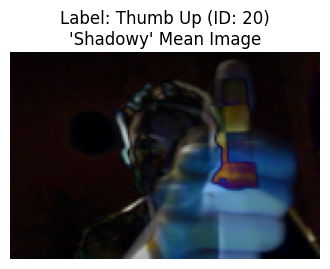

In [34]:
def show_random_baseline_image(dataset):
    """
    Picks a random sample from the dataset, converts the tensor back to a 
    viewable image, and displays it with its label.
    """
    idx = random.randint(0, len(dataset) - 1)

    img_tensor, label_idx = dataset[idx]
    
    # Matplotlib expects images in format (Height, Width, Channels)
    # so we permute dimensions: (3, H, W) -> (H, W, 3)
    img_view = img_tensor.permute(1, 2, 0).numpy()
    
    # We invert the class_to_idx dictionary to get the text back
    class_to_idx = dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    label_text = idx_to_class.get(label_idx, "Unknown")

    plt.figure(figsize=(4, 4))
    plt.imshow(img_view)
    plt.title(f"Label: {label_text} (ID: {label_idx})\n'Shadowy' Mean Image")
    plt.axis('off')
    plt.show()

show_random_baseline_image(baseline_data_valid)

If the function returns an input_dim error message, check the "root" and "personal_path" variables in the Data Loading process (the Class instance call). It falls into the "FileNotFound" exception of the class

## Model: my VGG, as I know well how that works (inside and out)

In [11]:
class TinyVGG(nn.Module):
    def __init__(self, num_classes=27):
        super().__init__()
        
        bias = True
        
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2,2)) # to halve the image
        )

        final_out_channels = 256
        
        self.layer1 = self.make_VGG_layers(in_channels=64, out_channels=128, stride=1, bias=False)
        self.layer2 = self.make_VGG_layers(in_channels=128, out_channels=128, stride=1, bias=False)
        # self.layer3 = self.make_VGG_layers(in_channels=128, out_channels=128, stride=1, bias=False)
        self.layer4 = self.make_VGG_layers(in_channels=128, out_channels=256, stride=1, bias=False)
        self.layer5 = self.make_VGG_layers(in_channels=256, out_channels=final_out_channels, stride=1, bias=False, use_pooling=False)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.head = nn.Sequential(
            nn.Linear(final_out_channels, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

        self._initialize_weights()

    def make_VGG_layers(self, in_channels, out_channels, stride, bias, use_pooling=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if use_pooling:
            layers.append(
                nn.MaxPool2d((2,2))  # halve the final
            )

        return nn.Sequential(*layers)

    # weights initialization for reproducibility
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:  # if bias exists, put it at 0
                    nn.init.constant_(m.bias, 0)

    def forward(self, x, return_intermediate=False):
        x = self.initial_conv(x)

        x = self.layer1(x)
        x = self.layer2(x)
        # x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avgpool(x)
        x = x.flatten(1)
        
        return self.head(x)

### Inspecting architecture with summary

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# model = MyConv().to(device)
model = TinyVGG(num_classes=27).to(device)

summary(model, input_size=(3, 100, 150))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 150]           1,792
       BatchNorm2d-2         [-1, 64, 100, 150]             128
              ReLU-3         [-1, 64, 100, 150]               0
            Conv2d-4         [-1, 64, 100, 150]          36,928
       BatchNorm2d-5         [-1, 64, 100, 150]             128
              ReLU-6         [-1, 64, 100, 150]               0
         MaxPool2d-7           [-1, 64, 50, 75]               0
            Conv2d-8          [-1, 128, 50, 75]          73,728
       BatchNorm2d-9          [-1, 128, 50, 75]             256
             ReLU-10          [-1, 128, 50, 75]               0
           Conv2d-11          [-1, 128, 50, 75]         147,456
      BatchNorm2d-12          [-1, 128, 50, 75]             256
             ReLU-13          [-1, 128, 50, 75]               0
        MaxPool2d-14          [-1,

## Train and Eval functions (mine, sorry but I've stayed here way too long, and I know how these work far better)

In [13]:
def calculate_test_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    
    # pre-allocate tensors on GPU to avoid repeated transfers
    with torch.no_grad():
        for imgs, labels in tqdm(loader):
            # data passed to gpu every batch
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            # forward pass
            outputs = model(imgs)
            _, preds = torch.max(outputs, dim=1)
            
            # calculating accuracy on GPU
            correct += (preds == labels).sum()
            total += labels.size(0)
    
    # moving final scalar to CPU
    accuracy = (correct.float() / total) * 100
    return accuracy.item()

def train_model(model, train_loader, test_loader, device, num_epochs=20, lr=0.001):
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    train_losses = []
    val_accuracies = []
    
    # use torch.amp for mixed precision training
    scaler = torch.amp.GradScaler('cuda') if device.type == 'cuda' else None
    
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        
        # training loop with progress bar
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
            # move to gpu once per batch
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            # zero gradients
            optimizer.zero_grad(set_to_none=True)  # More efficient than zeroing
            
            # mixed precision forward pass
            if scaler:
                with torch.amp.autocast(device_type='cuda'):
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                
                # Mixed precision backward pass and optimization
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            else:
                # standard precision, just in case
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        scheduler.step()
        # get the epoch numbers
        avg_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        # evaluate on the validation set
        val_accuracy = calculate_test_accuracy(model, test_loader, device)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch:02d}: Train loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    return train_losses, val_accuracies

## Data Loading and Training

In [ ]:
batch_size = 64
print(device)
if device == "cpu":
    num_workers = min(12, os.cpu_count() or 2)  # dynamic core loading; swap the hard limit (12) depending on the amount of ram available (<16)
else:
    num_workers = 4 # I have this temporarily I will just set it to 4 for me
# some computers can handle 12 core usage, but (with the assumption that we're calculating for video processing) we might run into OOM
# "Out of Memory" errors on the RAM side, not the VRAM side. Note that this is foe Data Loading only! inspect machine_limit.py file for more info
epochs = 20

train_loader = DataLoader(
    baseline_data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=worker_init_fn,
    generator=g,
    pin_memory=False,
)

val_loader = DataLoader(
    baseline_data_valid,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=worker_init_fn,
    pin_memory=False
)

for images, labels in train_loader:
    img_view = images[0].permute(1, 2, 0).numpy()

    plt.figure(figsize=(4, 4))
    plt.imshow(img_view)
    plt.axis('off')
    plt.show()

model = TinyVGG(num_classes=27).to(device)

cuda


In [ ]:

train_losses, test_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=val_loader,
    device=device,
    num_epochs=epochs,
    lr=0.001
)

Epoch 1/20:   0%|          | 0/371 [00:00<?, ?it/s]